In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.contrib.parmest import parmest
from pyomo.contrib.parmest.experiment import Experiment
import pandas as pd
from itertools import product
import idaes

## Data

In [2]:
"""
This data and the equation (``Expression``) in pyomo_model is from "Nonlinear Regression Analysis
and Its Applications - 1988 - Bates" p.33 Example

The equation: 
    reaction_velocity = theta[1] * substrate_concentration / (theta[2] + substrate_concentration)
    f(x, theta) = theta[1] * x / (theta[2] + x)
    
    -> theta[1] and theta[2] are parameters. we want to regress their values
    -> substrate concentration is the decison variable
    -> reaction_velocity is the response

"""
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
treated_velocity = np.array([
    [76, 47], 
    [97, 107], 
    [123, 139], 
    [159, 152], 
    [191, 201], 
    [207, 200]]
                           )
untreated_velocity = np.array([
    [67, 51], 
    [84, 86], 
    [98, 115], 
    [131, 124], 
    [144, 158], 
    [160, np.nan]]
                             )

# calculate the average velocity. we are taking the average horizontally / along the rows. axis =1
treated_avg_velocity = np.nanmean(treated_velocity, axis = 1)  
untreated_avg_velocity = np.nanmean(untreated_velocity, axis = 1)

data_f = {
    "substrate_concentration": substrate_concentration,
    "treated_avg_velocity": treated_avg_velocity,
    "untreated_avg_velocity": untreated_avg_velocity
       }

# Organizing the data in a list consisting of ``one key : one value dict``s
data_treated = [
    {"substrate_concentration" : float(sub_conc), "avg_velocity": float(treated_vel)} 
    for sub_conc, treated_vel in zip(data_f["substrate_concentration"], data_f["treated_avg_velocity"])
]

data_untreated = [
    {"substrate_concentration" : float(sub_conc), "avg_velocity": float(untreated_vel)} 
    for sub_conc, untreated_vel in zip(data_f["substrate_concentration"], data_f["untreated_avg_velocity"])
]
data_treated[1]

{'substrate_concentration': 0.06, 'avg_velocity': 102.0}

# **PARMEST**

## Creating an experiment class

In [3]:
class ReactionVelcoity(Experiment):

    # Defining the constructor
    def __init__(self, data):
        self.data = data
        self.model = None

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
        return self.model

    # Create the model. In create model we only set variables, parameters and equations 
    def create_model(self):
        m = self.model = pyo.ConcreteModel()

        # initial guess of theta[1] & theta[2]
        theta_initial = {1: 200, 2: 0.06}

        # theta[1] and theta[2] as Vars. theta here is defined as a vector.
        m.s = pyo.RangeSet(2)  
        # we need a range set b/c we have theta as a vector. 
        # instead of theta, if we used theta_1 and theta_2 with both being scalar. we would not require a range set.
        # I think that would be the easiest way, although using it as a vector is not hard.
        m.theta = pyo.Var(m.s, initialize = theta_initial)
        # fix all the regressed model parameters
        m.theta.fix()

        # substrate concentration (x) as a param, since the data is given          
        m.x = pyo.Param(initialize = self.data["substrate_concentration"])
        

        # reaction_velocity = f(substrate_concentration, theta), is obtained from this equation.
        # So we will set it as an ``Expression``
        m.reaction_velocity = pyo.Expression(expr = m.theta[1] * m.x / (m.theta[2] + m.x))
        

        # ======================================
        """
        When I used the built in ``"SSE"``, my model could not find parameter covariance matrix.
        That's why I created the Total_Cost_Obj to minimize the SSE.
        Seems like both ``FirstStageCost`` and ``SecondStageCost`` are required, otherwise it will show ``AttributeError``
        """
    
        # Stage-specific cost computation
        # m.FirstStageCost = pyo.Expression(initialize = 0)
        # m.SecondStageCost = pyo.Expression(expr = (self.data["avg_velocity"] - m.reaction_velocity) ** 2)

        # m.Total_Cost_Obj = pyo.Objective(expr = (m.FirstStageCost + m.SecondStageCost), sense = pyo.minimize)
        # ======================================

        return m

    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        # experiment outputs (all the given data)
        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # passing the data as a `list` of `tuple` in the experiment outputs
        m.experiment_outputs.update([
            (m.x, self.data["substrate_concentration"]),
            (m.reaction_velocity, self.data["avg_velocity"])
        ])

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((theta, pyo.ComponentUID(theta)) for theta in [m.theta[1], m.theta[2]])

        return m        
    

## Treated velocity

In [16]:
exp_list = []
n_data = len(data_treated)
for i in range(n_data):
    exp_list.append(ReactionVelcoity(data_treated[i]))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, tee = True, obj_function="SSE")

obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)

print("\n\ntheta values:")
print(theta)

print("\nSSE value: ", obj)

print("\nCovariance matrix:")
print(cov)

Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

## Untreated velocity

In [5]:
exp_list = []
data_treated = data_untreated
n_data = len(data_treated)
for i in range(n_data):
    exp_list.append(ReactionVelcoity(data_treated[i]))

# Creating Estimator object
pest = parmest.Estimator(exp_list, tee = True, obj_function = "SSE")

obj, theta_u, cov = pest.theta_est(calc_cov=True, cov_n=n_data)

print("\n\ntheta values:")
print(theta_u)

print("\nSSE value: ", obj)

print("\nCovariance matrix:")
print(cov)

Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

## Plotting

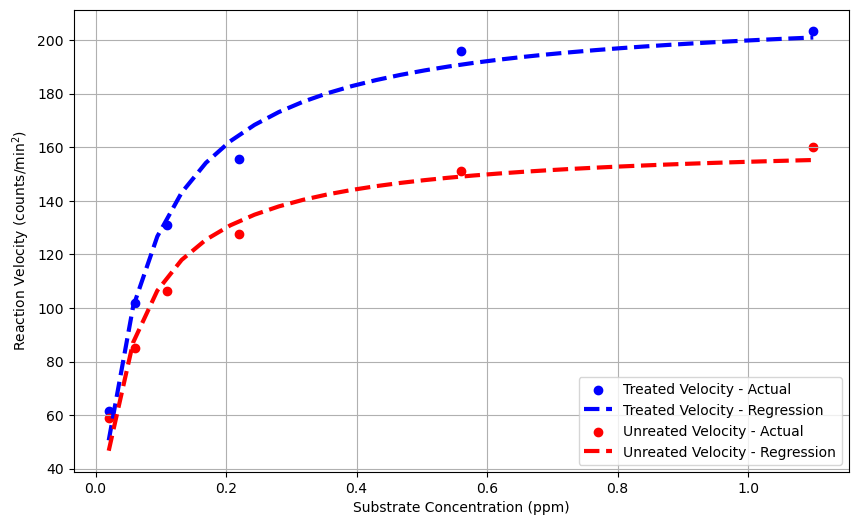

In [6]:
vel = lambda sub_conc, theta: theta.loc["theta[1]"] * sub_conc / ( theta.loc["theta[2]"] + sub_conc)

sub_c = np.linspace(data_f["substrate_concentration"][0], data_f["substrate_concentration"][-1], 30)

plt.figure(figsize=(10, 6))
# treated data
plt.scatter(data_f["substrate_concentration"], data_f["treated_avg_velocity"], color = "blue", label = "Treated Velocity - Actual")
plt.plot(sub_c, vel(sub_c, theta), lw =3, ls ="--", color = "blue", label="Treated Velocity - Regression")

# untreated data
plt.scatter(data_f["substrate_concentration"], data_f["untreated_avg_velocity"], color = "red", label = "Unreated Velocity - Actual")
plt.plot(sub_c, vel(sub_c, theta_u), lw =3, ls ="--", color = "red", label="Unreated Velocity - Regression")
plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()

### Confidence Region
The following sections used only treated velocity. Untreated velocity was not used. Since we can do that simpy by changing the data. The process stays the same.

Text(0.5, 1.0, 'Treated Fit with Confidence Region')

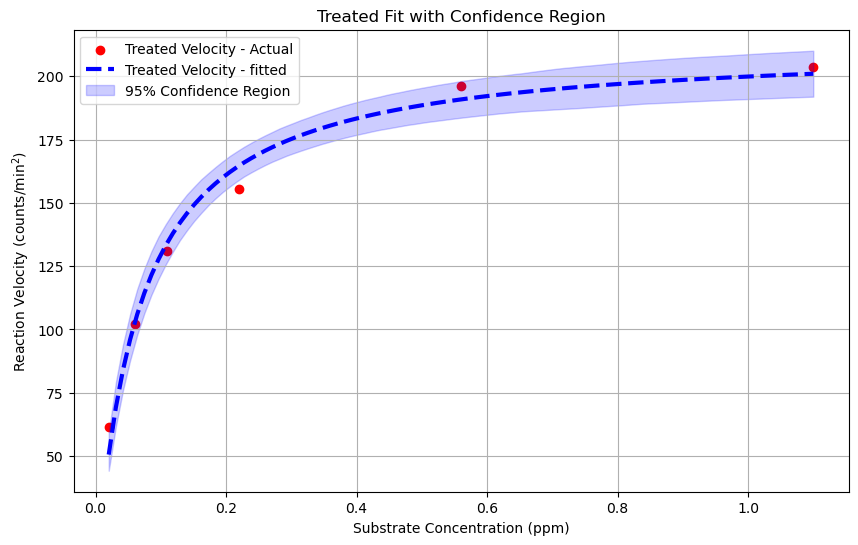

In [13]:
CI = 95  # The confidence interval 

# Calculate the standard errors (square root of diagonal elements of covariance matrix)
# Converting pd DF to numpy nd array
cov_n = np.array([
    [cov["theta[1]"].loc["theta[1]"], cov["theta[2]"].loc["theta[1]"]],
    [cov["theta[1]"].loc["theta[2]"], cov["theta[2]"].loc["theta[2]"]]
])
theta_n = np.array([theta.loc["theta[1]"], theta.loc["theta[2]"]])
perr = np.sqrt(np.diag(cov_n))  

# Our model equation
rxn_vel = lambda sub_conc, theta_p: theta_p[0] * sub_conc / ( theta_p[1] + sub_conc)

# Generate confidence bounds using Monte Carlo sampling
n_samples = 1000  # number of parameter samples
theta_samples = np.random.multivariate_normal(theta_n, cov_n, size = n_samples)

# Generate fitted curves for each sampled parameter set
S_range = np.linspace(min(data_f["substrate_concentration"]), max(data_f["substrate_concentration"]), 100)
predicted_curves = np.array([rxn_vel(S_range, theta_val) for theta_val in theta_samples])

# Compute confidence intervals
lower_bound = np.percentile(predicted_curves, 100 - CI, axis=0)
upper_bound = np.percentile(predicted_curves, CI, axis=0)

# Plot the results
plt.figure(figsize=(10,6))
#sub_c = np.linspace(data_f["substrate_concentration"][0], data_f["substrate_concentration"][-1], 30)

plt.scatter(data_f["substrate_concentration"], data_f["treated_avg_velocity"], color = "red", label = "Treated Velocity - Actual")
plt.plot(S_range, rxn_vel(S_range, theta_n), lw =3, ls ="--", color = "blue", label="Treated Velocity - fitted")
plt.fill_between(S_range, lower_bound, upper_bound, color = "blue", alpha=0.2, label=f"{CI}% Confidence Region")
plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()
plt.title("Treated Fit with Confidence Region")

In [12]:
cov_n

array([[8.40689105e-05, 4.80496665e-02],
       [4.80496665e-02, 4.62201766e+01]])

### Confidence Ellipsoid

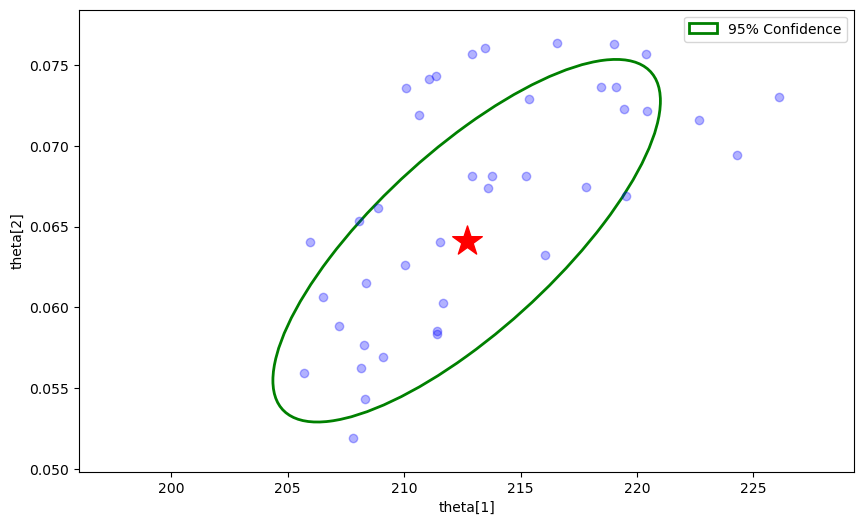

In [14]:
import scipy.stats as stat
from matplotlib.patches import Ellipse

CI = 95  # The confidence interval 


# Converting pd DF to numpy nd array. ``parmest`` can mess up the order of the theta estimates and also the covariance
# so it is not safe to use ``.to_numpy()`` or any equivalent conversion method. rather use the following.
cov_n = np.array([
    [cov["theta[1]"].loc["theta[1]"], cov["theta[2]"].loc["theta[1]"]],
    [cov["theta[1]"].loc["theta[2]"], cov["theta[2]"].loc["theta[2]"]]
])
theta_n = np.array([theta.loc["theta[1]"], theta.loc["theta[2]"]])


"""
# Generate parameter samples from the covariance matrix (multivariate normal)
n_samples = 100  # number of samples
theta_samples = np.random.multivariate_normal(theta_n, cov_n, size = n_samples)


# Plot the confidence ellipsoid
# We use Cholesky decomposition to ensure we are sampling from the correct distribution

plt.figure(figsize=(12, 6))
plt.scatter(theta_samples[:, 1], theta_samples[:, 0], color='blue', alpha=0.2, label="samples")

# Compute the confidence ellipsoid contours
mean = np.mean(theta_samples, axis=0)
cov_samples = np.cov(theta_samples.T)
"""

# Create the Ellipse object to represent the confidence region
eigvals, eigvecs = np.linalg.eig(cov_n)
order = eigvals.argsort()[::-1]  # returns the descending order index of the eigen values.
eigvals, eigvecs = eigvals[order], eigvecs[:, order]

# Define angle and width/height of the ellipse
chi2_val = stat.chi2.ppf(CI/100, df=2)  # Chi-square value for %CI, df -> 2 degrees of freedom (two parameters)
scale_factor = np.sqrt(chi2_val)
angle = np.arctan2(*eigvecs[:,0][::-1]) * 180 / np.pi
width, height = scale_factor * np.sqrt(eigvals)  # scaling for 95% Cofidence

# Plot the confidence ellipse
fig, ax = plt.subplots(figsize=(10, 6))

# Create the ellipse object
ellipse = Ellipse(xy=theta_n, width=width, height=height, angle=angle, facecolor='none', edgecolor="green", lw=2, label=f"{CI}% Confidence")
ax.add_patch(ellipse)

# add labels and formatting
ax.set_xlabel("theta[1]")
ax.set_ylabel("theta[2]")
ax.legend()
ax.set_xlim(theta_n[0] - width, theta_n[0] + width)
ax.set_ylim(theta_n[1] - height, theta_n[1] + height)
ax.scatter(theta_n[0], theta_n[1], color="red", marker="*", s=500)

# To plot some random points for our optimum theta.
# In reality our theta value could be any of these random points.
n_samples = 50  # number of scatter points we want to plot
np.random.seed(101)
theta_samples = np.random.multivariate_normal(theta_n, cov_n, size = n_samples)
ax.scatter(theta_samples[:, 0], theta_samples[:, 1], color='blue', alpha=0.3, label="samples")

## Likelyhood ratio 

In [15]:
# creating theta values where we want to find the LR
theta_1 = np.linspace(150, 250, 10)
theta_2 = np.linspace(0.03, 0.07, 10)

# creating a DF using these theta values
theta_vals = pd.DataFrame(
    list(product(theta_1, theta_2)), columns=["theta[1]", "theta[2]"]  
    # Names of the theta values as we defined in ``create_model``. our theta was basically a ``dict``
)

# Objective values for each theta value. Pre-requiste method for ``likelihood_ratio_test``
obj_at_theta = pest.objective_at_theta(theta_vals)

# Likelihood Ratio Test : to identify theta values within a confidence region using the distribution
LR = pest.likelihood_ratio_test(obj_at_theta, obj, [0.8, 0.85, 0.9, 0.95])
# the ``obj` here is from ``obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)``.
# The [0.8, 0.85, 0.9, 0.95] list is  alpha values (Confidence Level) for `chi2`` test

PyomoException: Cannot convert non-constant Pyomo numeric value (Total_Cost_Objective) to bool.
This error is usually caused by using a Var, unit, or mutable Param in a
Boolean context such as an "if" statement. For example,
    >>> m.x = Var()
    >>> if not m.x:
    ...     pass
would cause this exception.

In [ ]:
LR

## pairwise_plot (theta values - confidence level)

In [ ]:
# Create plot pairwise relationship for theta values, and optionally alpha-level confidence intervals and objective value contours
parmest.graphics.pairwise_plot(LR, theta, 0.9, title= "Likelihood Ratio results within 90% confidence region")


## bootstrap

In [ ]:
pest = parmest.Estimator(exp_list)
bootstrap_theta = pest.theta_est_bootstrap(50, seed=4581)

In [ ]:
parmest.graphics.pairwise_plot(bootstrap_theta, theta, title='Bootstrap theta')
parmest.graphics.pairwise_plot(
    bootstrap_theta,
    theta,
    0.8,
    ['MVN', 'KDE', 'Rect'],
    title='Bootstrap theta with 80% confidence regions',
)

# **DOE**

In [ ]:
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
treated_velocity = np.array([
    [76, 47], 
    [97, 107], 
    [123, 139], 
    [159, 152], 
    [191, 201], 
    [207, 200]])

treated_avg_velocity = np.nanmean(treated_velocity, axis = 1)

data_doe = {
    "substrate_concentration": substrate_concentration,
    "treated_avg_velocity": treated_avg_velocity,
       }

### DOE model

In [ ]:
class ReactionVelcoity(Experiment):

    # Defining the constructor
    def __init__(self, data):
        self.data = data
        self.model = None

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
        return self.model

    # Create the model. In create model we only set variables, parameters and equations 
    def create_model(self):
        m = self.model = pyo.ConcreteModel()

        # initial guess of theta[1] & theta[2]
        theta_initial = {1: 212.683743, 2: 0.064121}

        # create a index set for data points
        m.ind = np.arange(len(self.data["substrate_concentration"]))

        # theta[1] and theta[2] as Vars. theta here is defined as a vector.
        m.s = pyo.RangeSet(2)  
        # we need a range set b/c we have theta as a vector. 
        # instead of theta, if we used theta_1 and theta_2 with both being scalar. we would not require a range set.
        # I think that would be the easiest way, although using it as a vector is not hard.
        m.theta = pyo.Var(m.s, initialize = theta_initial)

        # substrate concentration (x) as a param, since the data is given          
        m.x = pyo.Param(initialize = self.data["substrate_concentration"])

        # reaction_velocity = f(substrate_concentration, theta), is obtained from this equation.
        # So we will set it as an ``Expression``
        # m.reaction_velocity = pyo.Expression(expr = m.theta[1] * m.x / (m.theta[2] + m.x))        
        @m.Constraint(m)
        def vel_con(m):
            return m.reaction_velocity == m.theta[1] * m.x / (m.theta[2] + m.x)
            
        return m

    
    def finalize_model(self):
        m.theta.fix() 

        # Add lower and upper bound to substrate concentration
        m.x.setlb(0)
        m.x.setub(2)

        # fixing the substrate conc
        m.x.fix(0.5)

        # m.x.update(self.data["substrate_concentration"])

    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        # experiment outputs 
        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)        
        m.experiment_outputs.update(m.reaction_velocity, None) 

        # Experiment inputs
        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)        
        m.experiment_inputs[m.x] = m.x
        # m.experiment_inputs.update(m.reaction_velocity[ind], None)       

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.theta[1], m.theta[2]])

        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.measurement_error.update((m.x, 0.03))        

        return m

In [ ]:
def run_reactor_doe():
    # Create a ReactorOrder object
    experiment = ReactionVelocity(data = data_doe)

    # Use the determinant (D-optimality) with scaled sensitivity matrix
    objective_option = "determinant"
    scale_nominal_param_value = True

    # # Create the DesignOfExperiment object
    # doe_obj = DesignOfExperiments(
    #     experiment,
    #     objective_option= objective_option,
    #     scale_nominal_param_value=scale_nominal_param_value,
    # )

    solver = pyo.SolverFactory("ipopt")
    solver.options["linear_solver"] = "MUMPS"
    
    # Create the DesignOfExperiments object
    doe_obj = DesignOfExperiments(
        experiment,
        objective_option= objective_option,
        scale_nominal_param_value=scale_nominal_param_value,
        solver=solver,
    )
    
    # I haven't defined the other parameters, because the defaults values are used in the doe example.
    print("FIM of the experiment:\n", doe_obj.compute_FIM())

In [ ]:
[range(1,7)]

In [ ]:
np.arange(7)